## Cassava Leaf Disease Classification models using ResNet50



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import cv2
import os
import keras
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation,add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import DenseNet201
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet169
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator

from keras import Sequential
from tqdm import tqdm
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
import zipfile
import os
import seaborn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

from google.colab import  drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/cassava-leaf-disease-classification.zip"
zip_file  = zipfile.ZipFile(path, 'r') 
zip_file.extractall()
train_images = os.listdir('./train_images')

Mounted at /content/drive


In [4]:
root_dir = "./"

train_df = pd.read_csv('./train.csv')
print("there are " + str(train_df.shape[0]) + " train samples" )
train_df.head()

there are 21397 train samples


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


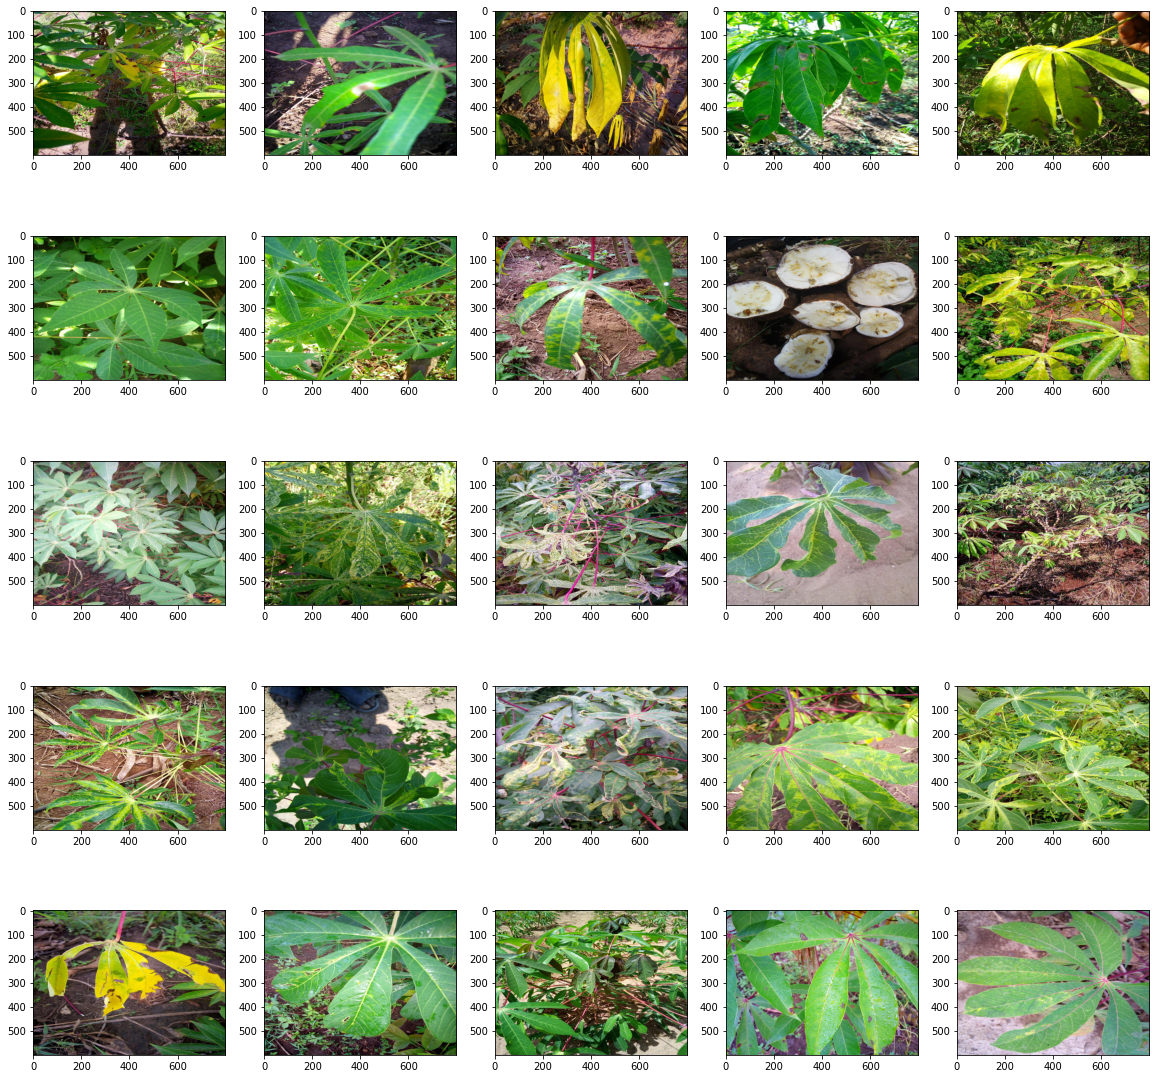

In [5]:
train_img_dir = os.path.join(root_dir, 'train_images')  

figure = plt.figure(figsize = (20,20))

cont = 0
    
for i in range(5):
    
    speci = train_df[train_df['label'] == i]
    
    for j in range(5):
        
        img = Image.open(os.path.join(train_img_dir, speci.iloc[j,0]))
        
        plt.subplot(5,5, cont+1)
        
        plt.imshow(img)
        
        cont = cont + 1

In [6]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop, Rescaling, RandomTranslation
image_preprocessor = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomCrop(150,150),
    RandomTranslation(0.3, 0.3),
    RandomRotation(0.5),
    Rescaling(1./255)])

In [7]:


def custom_gen(batch_size, image_dir, h = 150, w = 150):
    
    start = 0
    end = batch_size
    images = train_df['image_id']
    labels = train_df['label']
    while 1:
        
        if end >= train_df.shape[0]:
            start = 0
            end = batch_size 
            continue
        else:
        
            batch = []

            if start == 0:
                names = images[:end]
                y = to_categorical(labels[:end], num_classes = 5)
            else:
                names = images[start:end]
                y = to_categorical(labels[start:end], num_classes = 5)

            for name in names:

                img = cv2.imread(os.path.join(image_dir,name))
                img = np.expand_dims(img, axis = 0)
                img = image_preprocessor(img)
                img = np.squeeze(img, axis = 0)
                batch.append(img)



            end = end + batch_size
            start = start +  batch_size


            yield np.array(batch), y

In [8]:
base_model = tf.keras.applications.ResNet50(input_shape=(150,150,3),include_top=False,weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation = 'softmax'))

In [11]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization (BatchN  (None, 51200)            204800    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                      

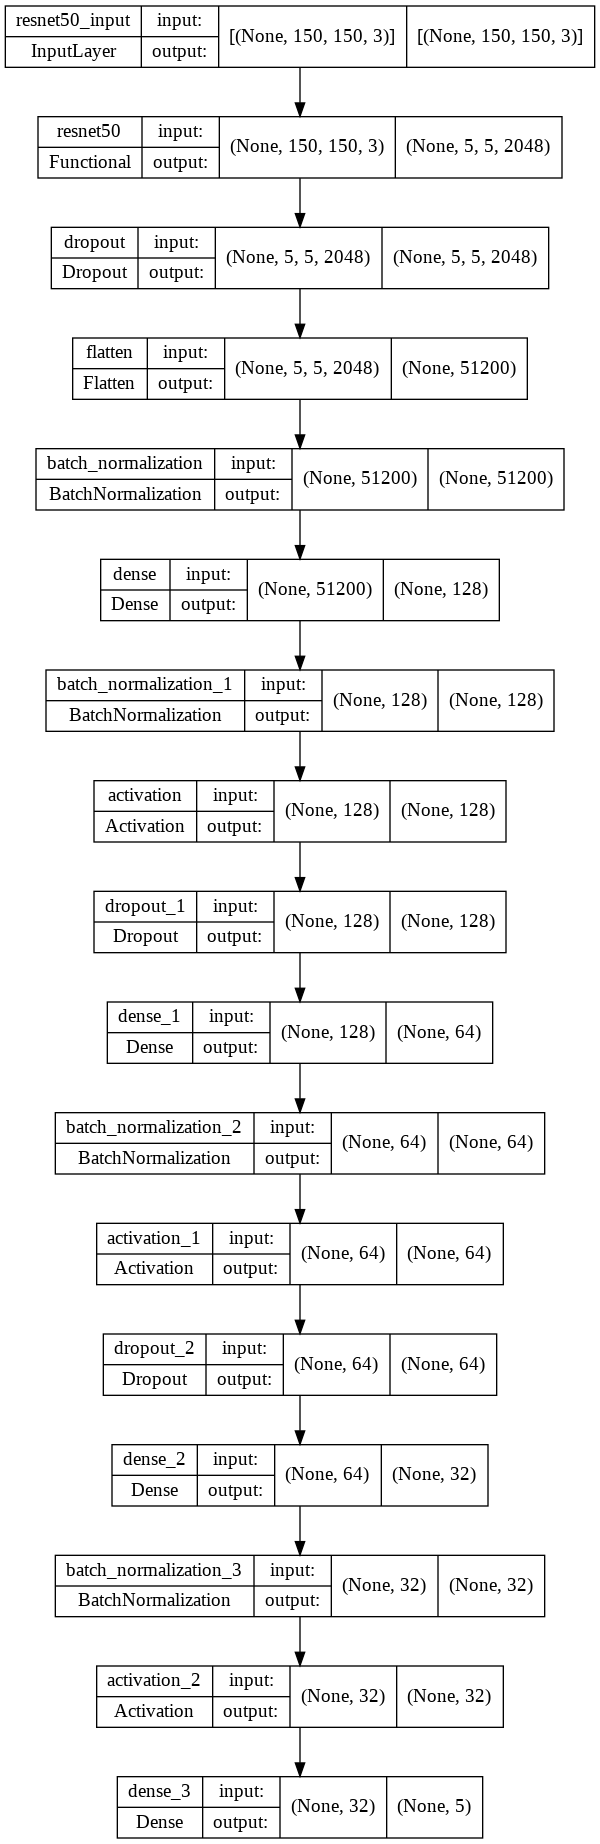

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [13]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.75, min_lr = 1e-4)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=2)

In [14]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

In [15]:
batch_size = 128
epochs = 5
steps_per_epoch = train_df.shape[0] // batch_size
train_gen = custom_gen(batch_size, train_img_dir)
%time
history = model.fit(train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch,verbose = 1,callbacks=[lrd,mcp,es] )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs
Epoch 1/5
60/60 [==============================] - 928s 15s/step - loss: 1.4458 - accuracy: 0.4422 - lr: 0.0010
Epoch 2/5
60/60 [==============================] - 908s 15s/step - loss: 1.2028 - accuracy: 0.6005 - lr: 0.0010
Epoch 3/5
60/60 [==============================] - 906s 15s/step - loss: 1.1638 - accuracy: 0.6156 - lr: 0.0010
Epoch 4/5
60/60 [==============================] - 917s 15s/step - loss: 1.1601 - accuracy: 0.6133 - lr: 0.0010
Epoch 5/5
60/60 [==============================] - 919s 15s/step - loss: 1.1559 - accuracy: 0.6113 - lr: 0.0010


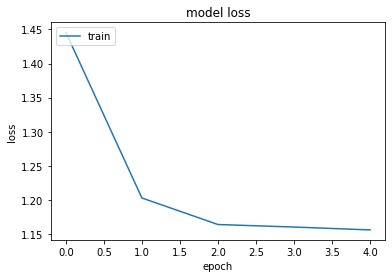

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
test_leaf = "./test_images"

test_names = pd.Series(os.listdir(test_leaf))


for j in range(3):

    for i in tqdm(range(len(test_names))):

        image = cv2.imread(os.path.join(test_leaf, test_names[i]))
        image = np.expand_dims(image, axis = 0)
        image = image_preprocessor(image)
        if i ==0:

            pred = model.predict(image)
        else:
            pred = np.concatenate([pred, model.predict(image)])
            
    if j ==0:
        final = pred
    else:
        final = final +pred
     
pred = pd.Series(np.argmax(final, axis = 1))


test_df = pd.concat([test_names, pred], axis = 1)
test_df = test_df.rename(columns = {0: 'image_id', 1: 'label'})

test_df.to_csv('submission.csv', index = False)


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


In [34]:
test_df

,image_id,label
0,2216849948.jpg,3
